In [1]:
import os 
import numpy as np 
import matplotlib.pyplot as plt 
from astropy.io import fits 
from astropy.stats import * 
from photutils.background import Background2D, MedianBackground, MMMBackground
from photutils.detection import DAOStarFinder 
from photutils.aperture import CircularAperture
from photutils.aperture import aperture_photometry

In [2]:
#First define the image in python as a string.
imagefile = "M13_g_align.fit" 
image = fits.open(imagefile)[0].data
header = fits.open(imagefile)[0].header

In [3]:
print(image.shape)

(2042, 3054)


/var/folders/ts/_gjzk30d5ggbnzxtbzmvs2240000gn/T/ipykernel_32093/1794141150.py:2: RuntimeWarning: invalid value encountered in log
  plt.imshow(np.log(image), #We usually take the log of an image to see the variance of the pixels better.


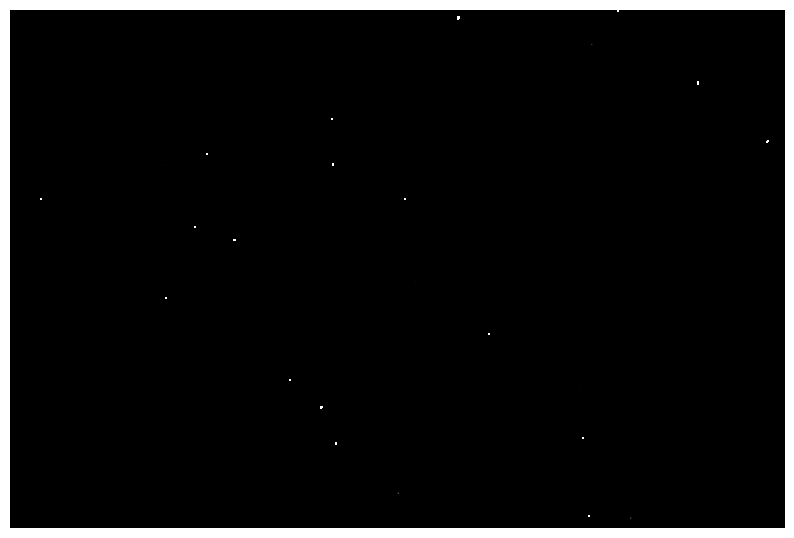

In [4]:
plt.figure(figsize=(10,10))
plt.imshow(np.log(image), #We usually take the log of an image to see the variance of the pixels better.
            origin='lower', #This tells matplotlib where the [0,0] index is. For our images it is in the bottom.
            cmap = "gray", #Use whatever colormap you like, but I find gray the easiest to visualize.
            vmin = 6, vmax = 11) #This defines the data range we want to see. There are ways to automate this but I always do it manually.
plt.axis('off') #This removes the axes, which aren't really relevant for just viewing an image.
plt.show()

In [5]:
mjd = header['MJD-OBS']
print("The Modified Julian Date is", mjd)

The Modified Julian Date is 60067.9566047


In [36]:
sigma_clip = SigmaClip(sigma_lower=3, sigma_upper=3, cenfunc='mean') #doesn't change much for inf sigma
mean, median, std = sigma_clipped_stats(image,sigma_lower=3, sigma_upper=3, cenfunc='mean') 

bkg_estimator = MedianBackground() 
bkg = Background2D(image, 
                    box_size=(10, 10), 
                    filter_size=(9, 9), 
                    sigma_clip=sigma_clip, 
                    bkg_estimator=bkg_estimator) 
bkg_ = bkg.background
bkg_median = bkg.background_median
bkg_rms = bkg.background_rms_median

mmm_bkg = MMMBackground()

daofind = DAOStarFinder(fwhm=0.1, #smaller <1, more bright stars
                        threshold=std*3,
                        brightest= 200
                       ) 
sources = daofind(image - bkg_median) #doesn't change if not subtract bkg
print(sources)


 id     xcentroid      ...        flux                mag        
--- ------------------ ... ------------------ -------------------
  1  2711.177876384477 ...  811.0494995117188  -7.272618401584535
  2 110.08191407814282 ...  163.1604461669922  -5.531537210593976
  3  3033.223048903094 ...  76.40100860595703 -4.7077477298525165
  4 1530.0216852095682 ...  49.44880294799805  -4.235389456750514
  5 2444.9586444421284 ...  30.11050033569336  -3.696794930232029
  6 2956.2193100334266 ... 28.867063522338867  -3.651006519720292
  7 1869.1672148726027 ...   23.8585147857666  -3.444108512373722
...                ... ...                ...                 ...
194  1673.903866922226 ... 1.6182290315628052 -0.5225999707318459
195  2318.683200601849 ... 1.6178841590881348 -0.5223685569887955
196 1419.9867626570226 ... 1.6107068061828613 -0.5175412345904913
197  3004.782514903858 ... 1.6055272817611694 -0.5140442241765247
198 1889.9708565045546 ...  1.602020263671875 -0.5116700127432388
199 2210.0

In [12]:
image_ = (image - bkg_median)
brightest = sorted(image_.flatten())[:18]
print(mean, median, std, sorted(image_.flatten())[:10])
print(bkg_median,bkg_rms)
print(np.where(image==brightest))
print(np.nanstd(image))

34.757893 34.711033 3.5849087 [-1577.5168, -930.7433, -529.2659, -386.7416, -365.0318, -316.4953, -315.48935, -287.74963, -252.09816, -224.35695]
34.602386474609375 3.3821142908216597
(array([], dtype=int64),)
16.197168


/var/folders/ts/_gjzk30d5ggbnzxtbzmvs2240000gn/T/ipykernel_32093/1379437242.py:5: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  print(np.where(image==brightest))


/var/folders/ts/_gjzk30d5ggbnzxtbzmvs2240000gn/T/ipykernel_32093/902176125.py:6: RuntimeWarning: invalid value encountered in log
  plt.imshow(np.log(image), origin='lower', cmap = "gray", vmin=4, vmax = 11)


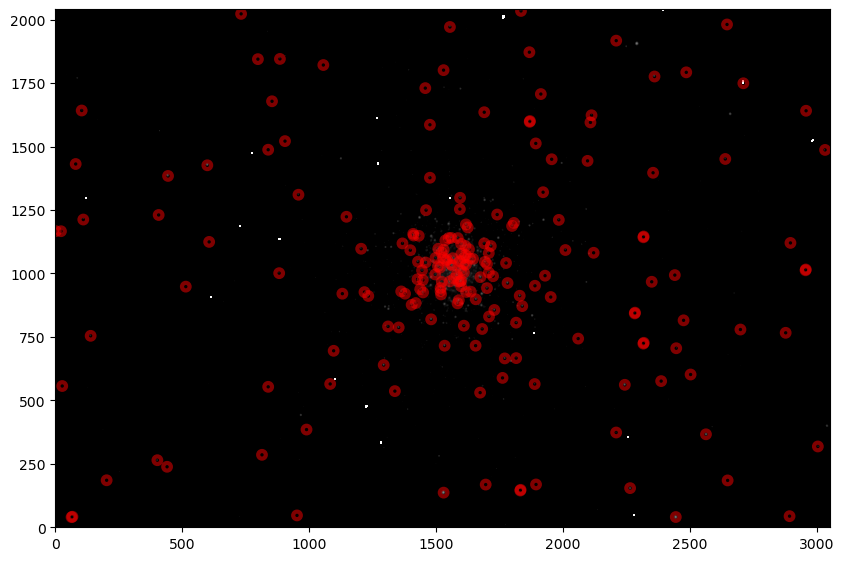

In [35]:
positions = np.transpose((sources['xcentroid'], sources['ycentroid'])) #Positions are transposed by default.
apertures = CircularAperture(positions, r=15) #This defines an 'aperture' by radius around each source. The pixel values inside the aperture are summed to yield the photon count of the star.

#Lets plot our image again with the apertures overplotted to see how many stars we found.
plt.figure(figsize=(10,10))
plt.imshow(np.log(image), origin='lower', cmap = "gray", vmin=4, vmax = 11)
v = apertures.plot(color='red', lw=3, alpha=0.5) 
plt.show()

In [28]:
for bright in brightest:
    positions = list(positions)
    positions.append(np.where(image==bright))
    
positions = np.array(positions)
print(positions.shape)

(111, 2)


/var/folders/ts/_gjzk30d5ggbnzxtbzmvs2240000gn/T/ipykernel_32093/942857213.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  positions = np.array(positions)


/var/folders/ts/_gjzk30d5ggbnzxtbzmvs2240000gn/T/ipykernel_32093/902176125.py:6: RuntimeWarning: invalid value encountered in log
  plt.imshow(np.log(image), origin='lower', cmap = "gray", vmin=4, vmax = 11)


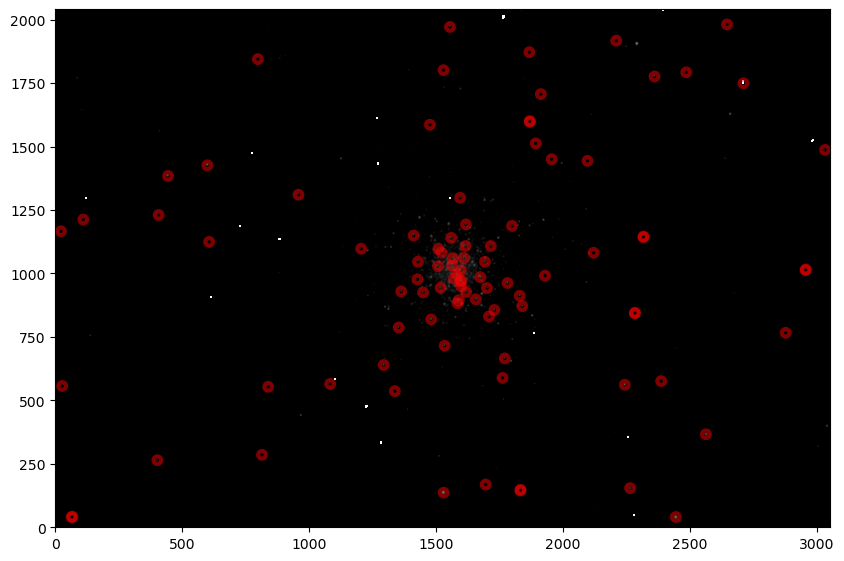

In [29]:
positions = np.transpose((sources['xcentroid'], sources['ycentroid'])) #Positions are transposed by default.
apertures = CircularAperture(positions, r=15) #This defines an 'aperture' by radius around each source. The pixel values inside the aperture are summed to yield the photon count of the star.

#Lets plot our image again with the apertures overplotted to see how many stars we found.
plt.figure(figsize=(10,10))
plt.imshow(np.log(image), origin='lower', cmap = "gray", vmin=4, vmax = 11)
v = apertures.plot(color='red', lw=3, alpha=0.5) 
plt.show()

/var/folders/ts/_gjzk30d5ggbnzxtbzmvs2240000gn/T/ipykernel_32093/3594760197.py:3: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(image_), origin='lower', cmap = "gray", vmin=5, vmax = 10)
/var/folders/ts/_gjzk30d5ggbnzxtbzmvs2240000gn/T/ipykernel_32093/3594760197.py:3: RuntimeWarning: invalid value encountered in log
  plt.imshow(np.log(image_), origin='lower', cmap = "gray", vmin=5, vmax = 10)


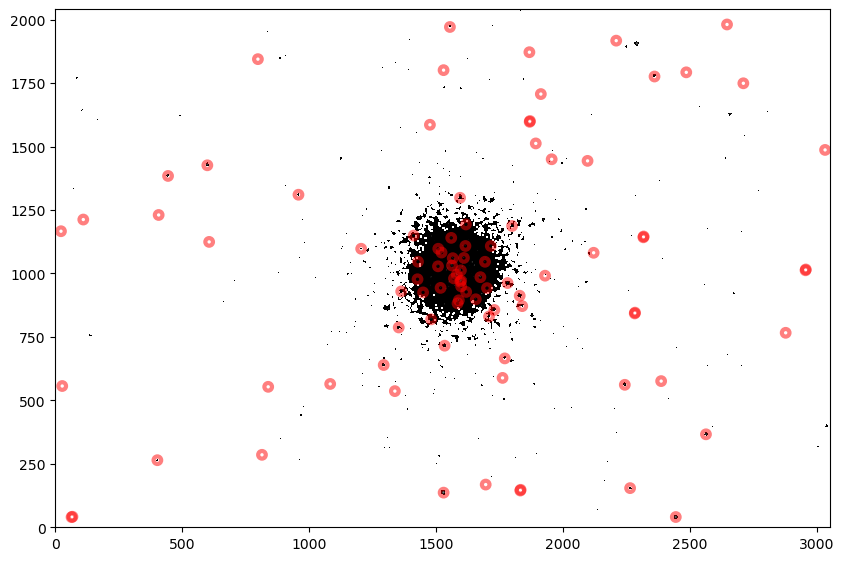

In [30]:
image_ = (image - bkg_median)
plt.figure(figsize=(10,10))
plt.imshow(np.log(image_), origin='lower', cmap = "gray", vmin=5, vmax = 10)
v = apertures.plot(color='red', lw=3, alpha=0.5) #I define it as a variable to avoid unnecessary readout.
plt.show()